# Análisis Exploratorio de Datos (EDA): 

## Objetivo
Este notebook contiene el análisis exploratorio completo del dataset, siguiendo una estructura organizada y metódica para entender los datos, limpiarlos y prepararlos para modelado.

## Contenido
1. Configuración Inicial y librearías
2. Limpieza
    - Carga de datos sucios
3. Análisis Exploratorio de los Datos
    - Carga de datos limpios
4. Análisis estadístico
5. Análisis Univariante
6. Análisis Bivariante
7. Conclusiones

# 1. Configuración Inicial

Importamos las bibliotecas necesarias y configuramos el entorno de trabajo.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import os
import re

### Configuración del estilo visual

In [5]:
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', None) 
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows
# pd.set_option('display.max_colwidth', None) # Show entire content of each column
pd.set_option('display.width', None)        # No limit on display width
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping

### Setting paths

In [6]:
# Setting paths
current_dir = os.getcwd()  # Use os.getcwd() to get the current working directory
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "data")
file_path = os.path.join(data_dir, "")
cars_csv_path = os.path.join(data_dir, "raw_data.csv")
clean_data_car_csv_path = os.path.join(data_dir, "clean_data_car.csv")
train_csv_path = os.path.join(data_dir, "train_csv.csv")
test_csv_path = os.path.join(data_dir, "test_csv.csv")

In [7]:
df_car = pd.read_csv(clean_data_car_csv_path)

In [14]:
df_car.sample(5)

,id,brand,model,model_year,milage,fuel_type,engine,engine_hp,engine_cc,engine_cylinder,transmission,transmission_types,transmission_num,ext_col,int_col,accident,price
18097,18129,BMW,335 i xDrive,2011,73000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,300.0,3000.0,6.0,Transmission w/Dual Shift Mode,Dual,6,White,Black,True,11500
181637,181977,BMW,i8 Base,2018,41500,Plug-In Hybrid,369.0HP 1.5L 3 Cylinder Engine Plug-In Electri...,369.0,1500.0,3.0,Transmission w/Dual Shift Mode,Dual,6,Black,Black,False,51750
33049,33108,Ford,Bronco Sport Outer Banks,2022,8400,Gasoline,315.0HP 2.7L V6 Cylinder Engine Gasoline Fuel,315.0,2700.0,6.0,10-Speed A/T,Automatic,10,Gray,Black,False,59900
149909,150174,GMC,Sierra 2500 Base,2021,8210,Gasoline,401.0HP 6.6L 8 Cylinder Engine Gasoline Fuel,401.0,6600.0,8.0,A/T,Automatic,10,Blue,Black,False,62000
2727,2731,Chrysler,300C Base,2007,122000,Gasoline,340.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,340.0,5700.0,8.0,5-Speed A/T,Automatic,5,Gray,Beige,False,14500


In [15]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188181 entries, 0 to 188180
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  188181 non-null  int64  
 1   brand               188181 non-null  object 
 2   model               188181 non-null  object 
 3   model_year          188181 non-null  int64  
 4   milage              188181 non-null  int64  
 5   fuel_type           182317 non-null  object 
 6   engine              188181 non-null  object 
 7   engine_hp           155049 non-null  float64
 8   engine_cc           181499 non-null  float64
 9   engine_cylinder     173040 non-null  float64
 10  transmission        188181 non-null  object 
 11  transmission_types  188181 non-null  object 
 12  transmission_num    188181 non-null  int64  
 13  ext_col             188181 non-null  object 
 14  int_col             188181 non-null  object 
 15  accident            188181 non-nul

# 3. Análisis exploratorio de datos
En este apartado analizaremos los precios de los vehículos en función de distintas variables.


In [8]:
# Creating dataframe of clean data
df_car_clean = pd.read_csv(clean_data_car_csv_path)
df_car_clean.sample(5)

,id,brand,model,model_year,milage,fuel_type,engine,engine_hp,engine_cc,engine_cylinder,transmission,transmission_types,transmission_num,ext_col,int_col,accident,price
53219,53322,Acura,TLX PMC Edition,2024,25348,Gasoline,355.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,355.0,3000.0,6.0,Transmission w/Dual Shift Mode,Dual,6,White,Black,False,76900
118917,119134,Ford,Mustang SVT Cobra,2003,142500,Gasoline,390.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,390.0,4600.0,8.0,A/T,Automatic,8,Black,Gray,True,9000
125314,125544,Mercedes-Benz,G-Class G 550 4MATIC,2016,65000,Gasoline,416.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,416.0,4000.0,8.0,A/T,Automatic,7,Black,Brown,True,21500
166452,166752,Kia,Sorento EX,2020,74595,Gasoline,2.3L I4 16V GDI DOHC Turbo,NaN,2300.0,4.0,10-Speed Automatic,Automatic,10,White,Satin Black,False,35707
96576,96764,Audi,Q5 S line Premium Plus,2021,5682,Gasoline,2.0L I4 16V GDI SOHC Turbo,NaN,2000.0,4.0,8-Speed Automatic,Automatic,8,White,Sahara Tan,False,25221


### Distribución de precios
- La distribución de precios es asimétrica a la derecha, con una alta frecuencia de vehículos a precios más bajos y una larga cola que indica un número menor de vehículos significativamente más caros, representando las gamas más altas del mercado.
- La mayoría de los vehículos se encuentran en el rango de precios más bajo, lo que sugiere que la mayoría de los compradores buscan opciones más asequibles en el mercado de segunda mano.

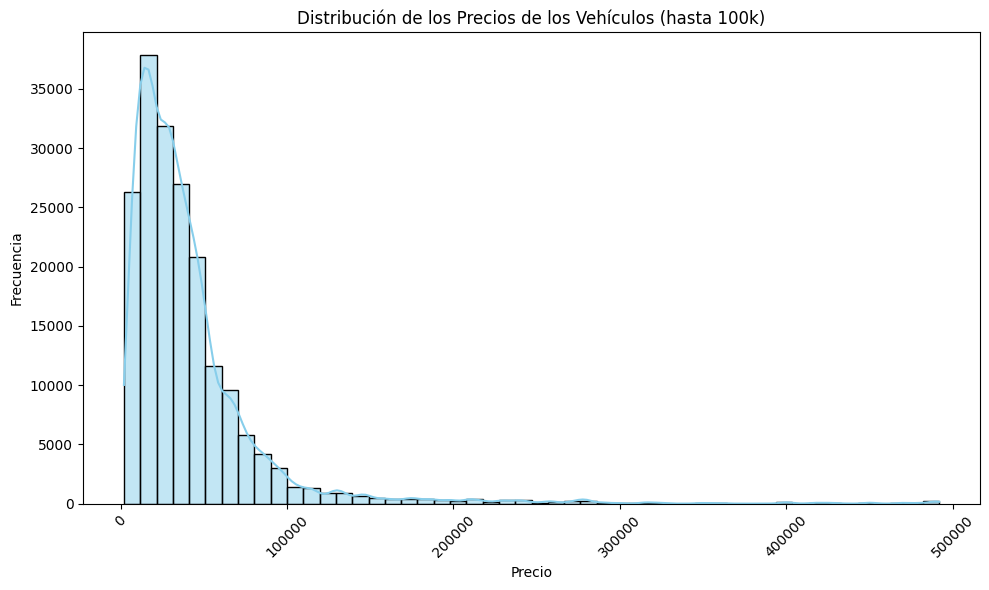

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df_car_clean['price'], bins=50, kde=True, color='skyblue')
plt.title('Distribución de los Precios de los Vehículos (hasta 100k)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Quitar notación científica y limitar el eje X
plt.ticklabel_format(axis='x', style='plain')
#plt.xlim(0, 100000)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Mapa de calor de correlaciones

En este análisis, generamos un mapa de calor para visualizar las correlaciones entre las variables numéricas del dataset.

Observamos las siguientes correlaciones significativas con la variable precio:
- La variable "milage" o kilometraje muestra una correlación negativa con el precio, lo que indica que a medida que aumenta el kilometraje, disminuye el precio del vehículo.
- La variable "model_year" presenta una correlación positiva con el precio, sugiriendo que los vehículos más nuevos tienden a tener precios más altos.
- La variable engine muestra una correlación positiva con el precio, lo que indica que a medida que aumenta el tamaño/potencia/cilindrada del motor, también lo hace el precio del vehículo.

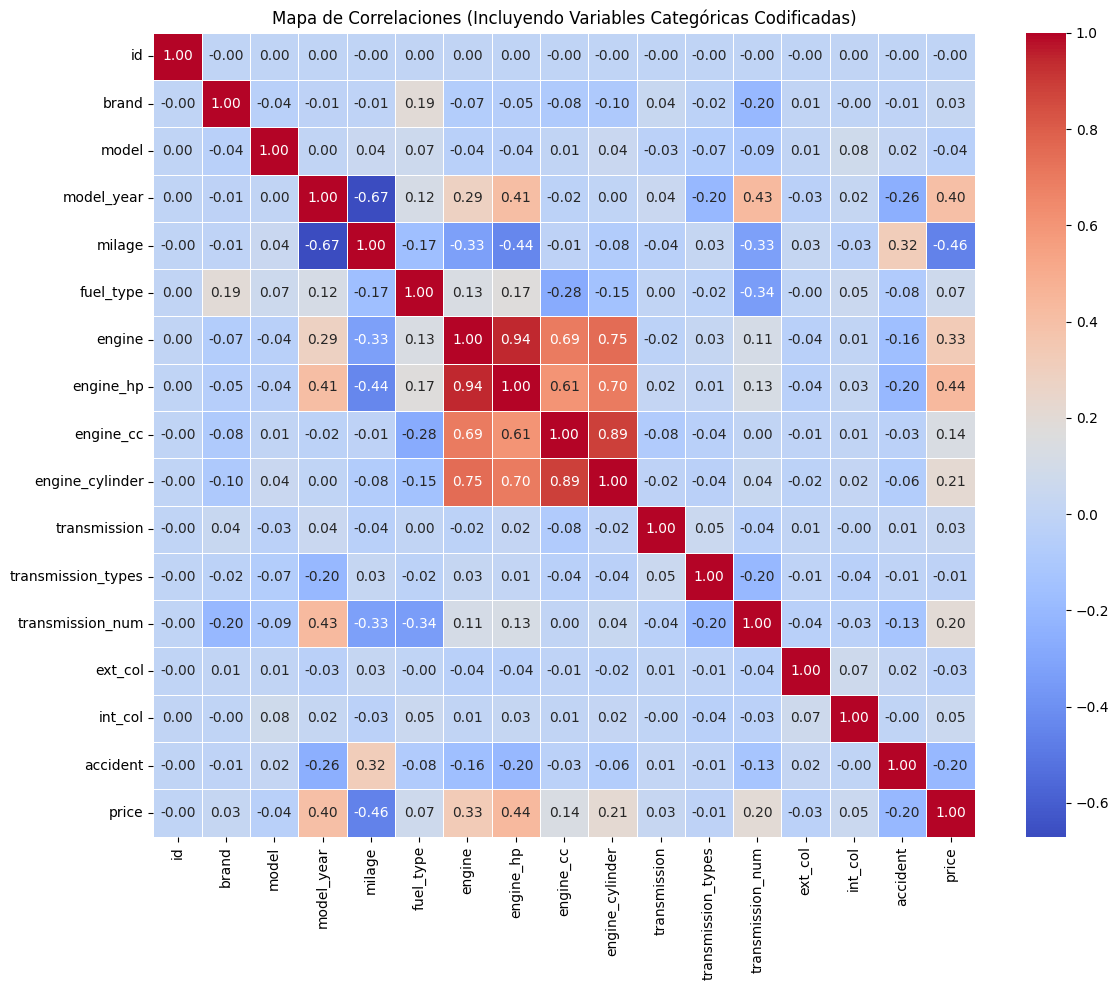

In [18]:
# Copiar el DataFrame original para no modificarlo directamente
df_encoded = df_car_clean.copy()

# Codificar las columnas categóricas con LabelEncoder
label_encoder = LabelEncoder()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Crear el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlaciones (Incluyendo Variables Categóricas Codificadas)')
plt.tight_layout()
plt.show()


## Estimación de Densidad Kernel

### Gráfico KDE del precio por año del modelo
- El gráfico de densidad muestra la distribución del precio de los vehículos según el año del modelo.
- La mayoría de los vehículos más nuevos tienen precios más altos, lo que es consistente con la correlación observada anteriormente.
- La distribución de precios para los vehículos más antiguos es más amplia, lo que sugiere una mayor variabilidad en los precios de los vehículos más viejos.

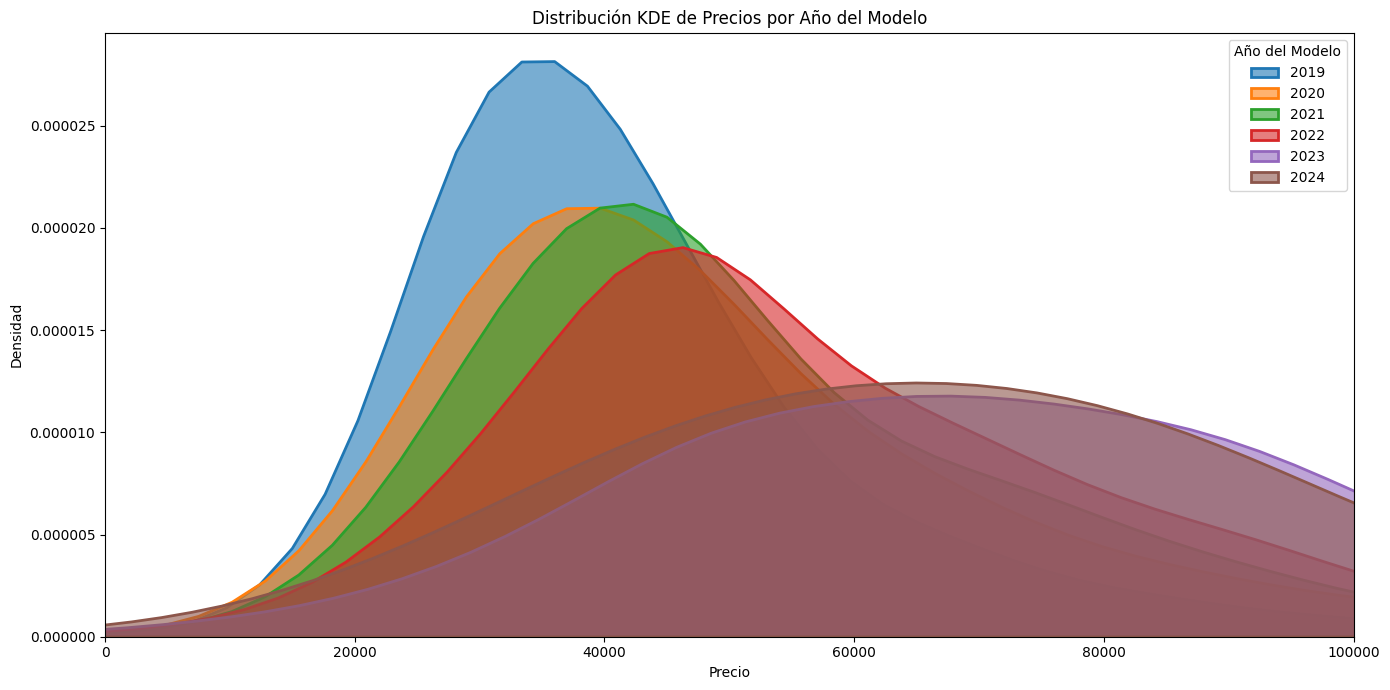

In [43]:
plt.figure(figsize=(14, 7))
# Obtener los años más comunes o últimos N años
years = sorted(df_car_clean['model_year'].dropna().unique())[-6:]  # Últimos 6 años

# Graficar curvas KDE superpuestas
for year in years:
    subset = df_car_clean[df_car_clean['model_year'] == year]
    if len(subset) > 1:
        sns.kdeplot(
            data=subset,
            x='price',
            fill=True,
            linewidth=2,
            label=int(year),
            alpha=0.6
        )


plt.title('Distribución KDE de Precios por Año del Modelo')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.ticklabel_format(style='plain', axis='y')  # Quitar notación científica
plt.xlim(0, 100000)
plt.legend(title='Año del Modelo')
plt.tight_layout()
plt.show()


### Gráfico KDE del precio por kilometraje
- Densidad de precios por kilometraje
    - Este gráfico de densidad muestra la distribución de los precios de los vehículos según el kilometraje de los mismos.
    - La mayoría de los vehículos con menor kilometraje tienen precios más altos, lo que indica que los vehículos menos usados tienden a tener un precio más elevado.
    - La distribución de precios para los vehículos con mayor kilometraje es más amplia, lo que sugiere una mayor variabilidad en los precios de los vehículos más usados.

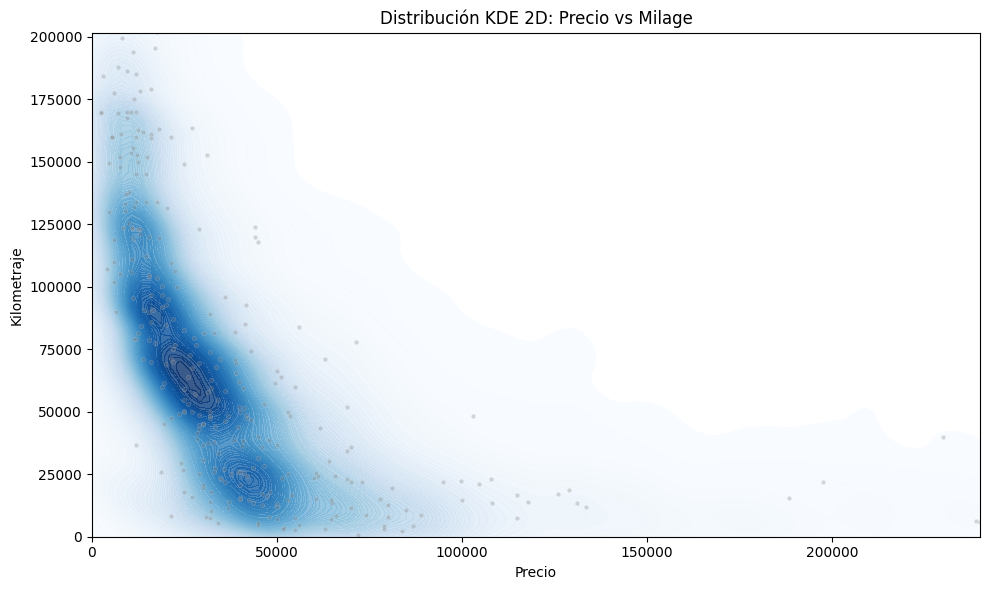

In [44]:
plt.figure(figsize=(10, 6))
# Asegurarse de que no haya NaNs
df_filtered = df_car_clean[['price', 'milage']].dropna()

# KDE 2D con precio en eje X y milage en eje Y
sns.kdeplot(
    data=df_filtered,
    x='price',
    y='milage',
    fill=True,
    cmap='Blues',
    thresh=0.01,
    levels=100,
    alpha=0.8
)

# Puntos reales (muestra aleatoria para que no sature)
sns.scatterplot(
    data=df_filtered.sample(300),
    x='price',
    y='milage',
    color='gray',
    alpha=0.3,
    s=10
)

plt.title('Distribución KDE 2D: Precio vs Milage')
plt.xlabel('Precio')
plt.ylabel('Kilometraje')
plt.ticklabel_format(style='plain', axis='both')  # Quitar notación científica

# Limitar extremos para mejor visualización
plt.xlim(0, df_filtered['price'].quantile(0.99))
plt.ylim(0, df_filtered['milage'].quantile(0.99))

plt.tight_layout()
plt.show()


### Relación entre variables numéricas

En este análisis, generamos un gráfico de pares para visualizar la relación entre todas las variables numéricas del dataset. Este gráfico nos permite identificar patrones, tendencias y posibles correlaciones entre las variables.

Coincidiendo con el mapa de calor, podemos comprobar que la variable "price" tiene correlación positiva con "model_year" y negativa con "milage", representadas con asimetría derecha e izquierda respectivamente, lo que indica que a medida que aumenta el año del modelo o disminuye el kilometraje, el precio tiende a aumentar.

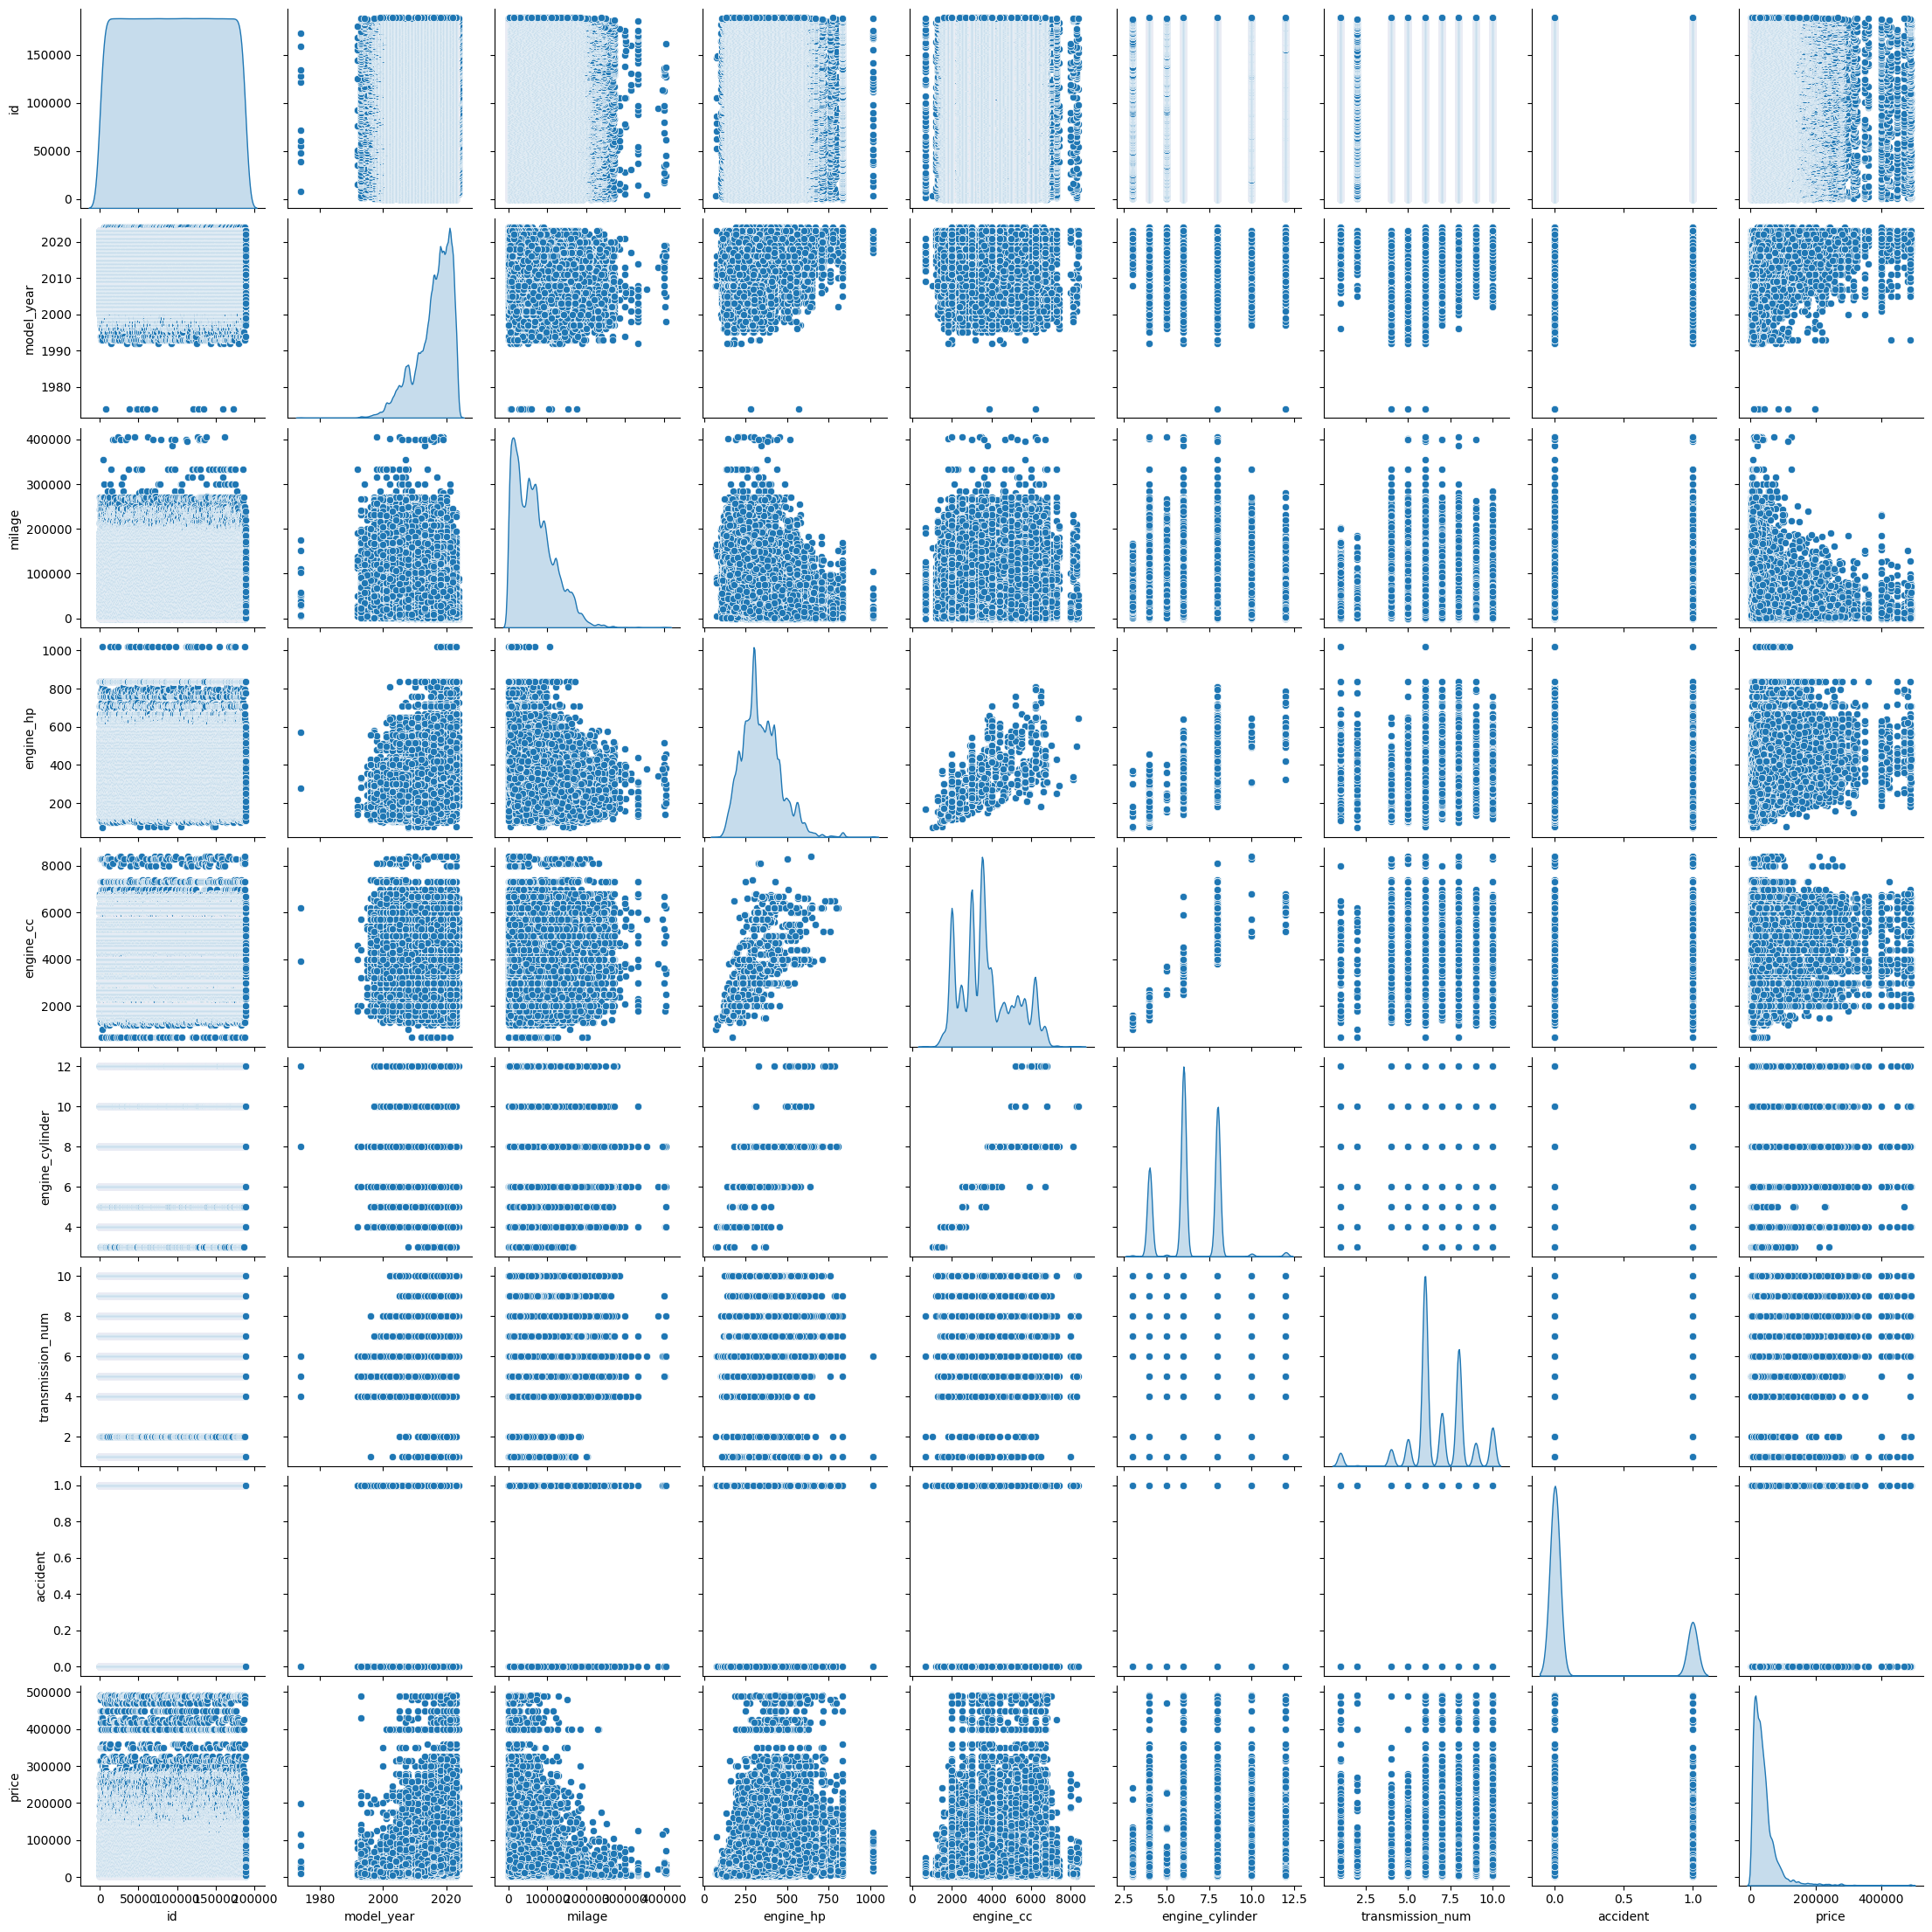

<Figure size 1000x800 with 0 Axes>

In [21]:
sns.pairplot(df_car_clean, diag_kind='kde')
plt.figure(figsize=(10, 8))
plt.suptitle('Relación entre Variables Numéricas', y=1.02)
plt.show()

### Definición de las variables predictoras

- Según lo contemnplado en los gráficos anteriores y debido a su alta correlación, las variables predictoras para el precio incluirán: año del modelo, kilometraje, caballos de fuerza, número de cilindos, número de marchas y si el vehículo a sufrido o no accidentes.


### Tendencia

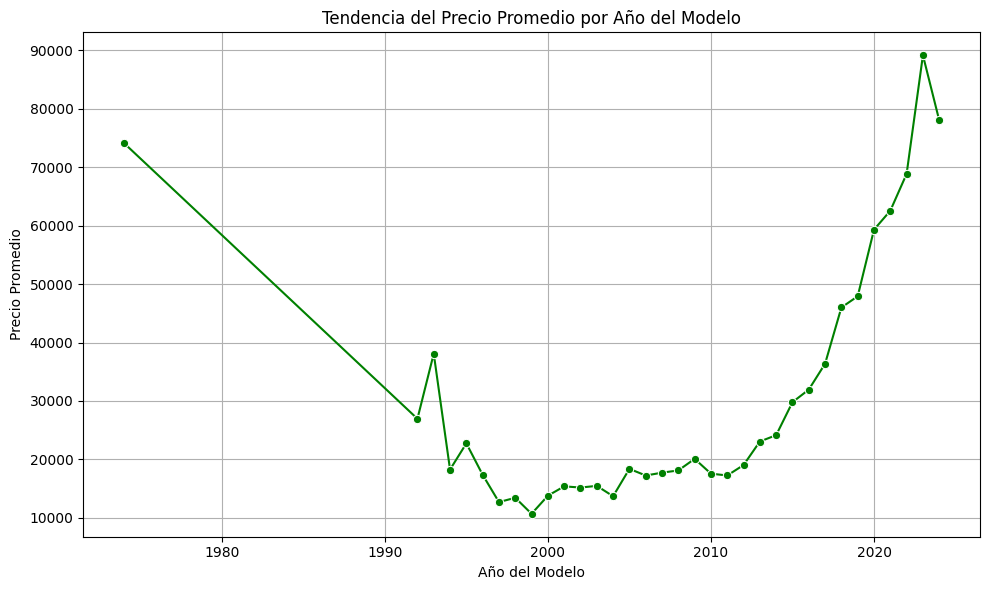

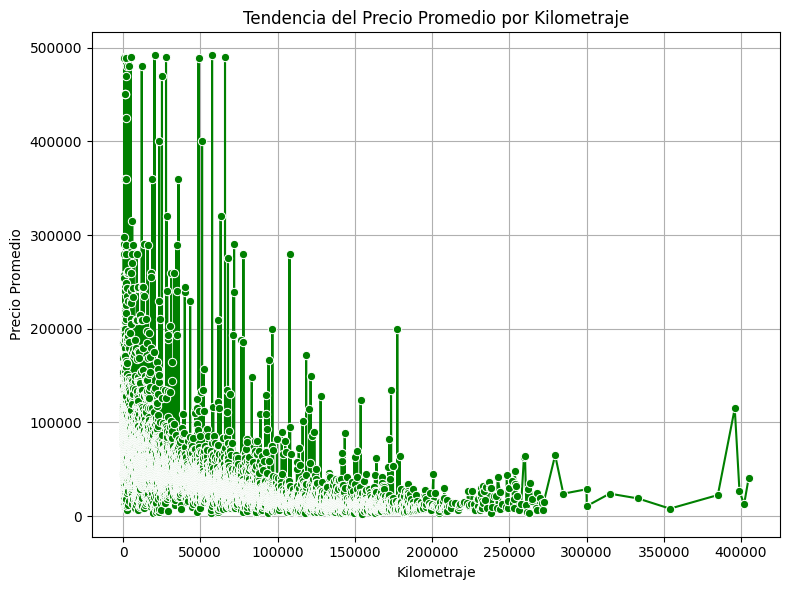

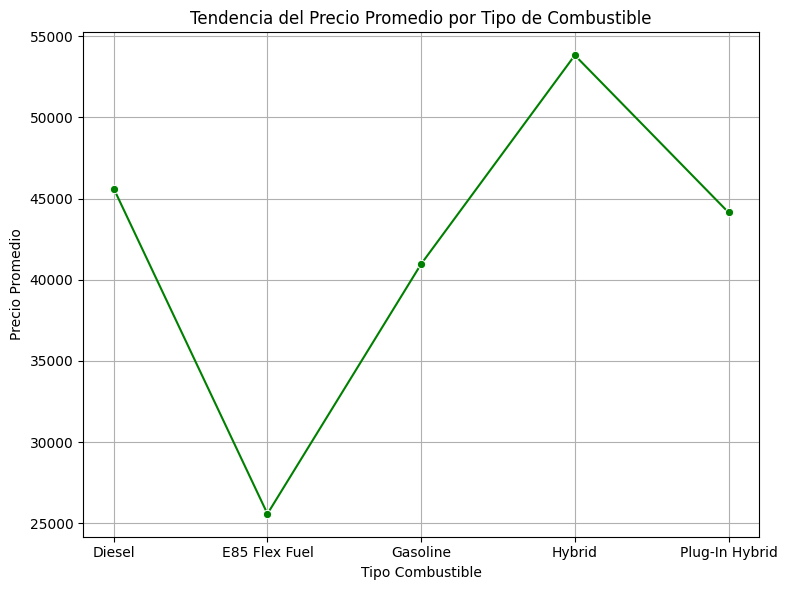

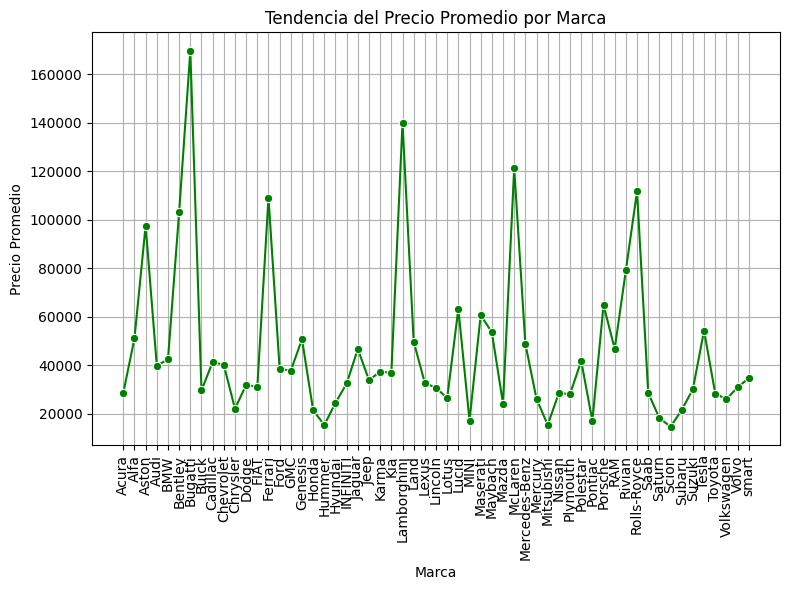

In [22]:
# Calcular precio promedio por año del modelo
avg_price_by_year = df_car_clean.groupby('model_year')['price'].mean().reset_index()

# Crear gráfico de línea
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_price_by_year, x='model_year', y='price', marker='o', color='green')
plt.title('Tendencia del Precio Promedio por Año del Modelo')
plt.xlabel('Año del Modelo')
plt.ylabel('Precio Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular precio promedio por media de kilometraje
avg_price_by_milage = df_car_clean.groupby('milage')['price'].mean().reset_index()

# Crear gráfico de línea
plt.figure(figsize=(8, 6))
sns.lineplot(data=avg_price_by_milage, x='milage', y='price', marker='o', color='green')
plt.title('Tendencia del Precio Promedio por Kilometraje')
plt.xlabel('Kilometraje')
plt.ylabel('Precio Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()


# Calcular precio promedio por motor
avg_price_by_fuel_type = df_car_clean.groupby('fuel_type')['price'].mean().reset_index()

# Crear gráfico de línea
plt.figure(figsize=(8, 6))
sns.lineplot(data=avg_price_by_fuel_type, x='fuel_type', y='price', marker='o', color='green')
plt.title('Tendencia del Precio Promedio por Tipo de Combustible')
plt.xlabel('Tipo Combustible')
plt.ylabel('Precio Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular precio promedio por motor
avg_price_by_brand = df_car_clean.groupby('brand')['price'].mean().reset_index()

# Crear gráfico de línea
plt.figure(figsize=(8, 6))
sns.lineplot(data=avg_price_by_brand, x='brand', y='price', marker='o', color='green')
plt.title('Tendencia del Precio Promedio por Marca')
plt.xlabel('Marca')
plt.xticks(rotation=90)
plt.ylabel('Precio Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

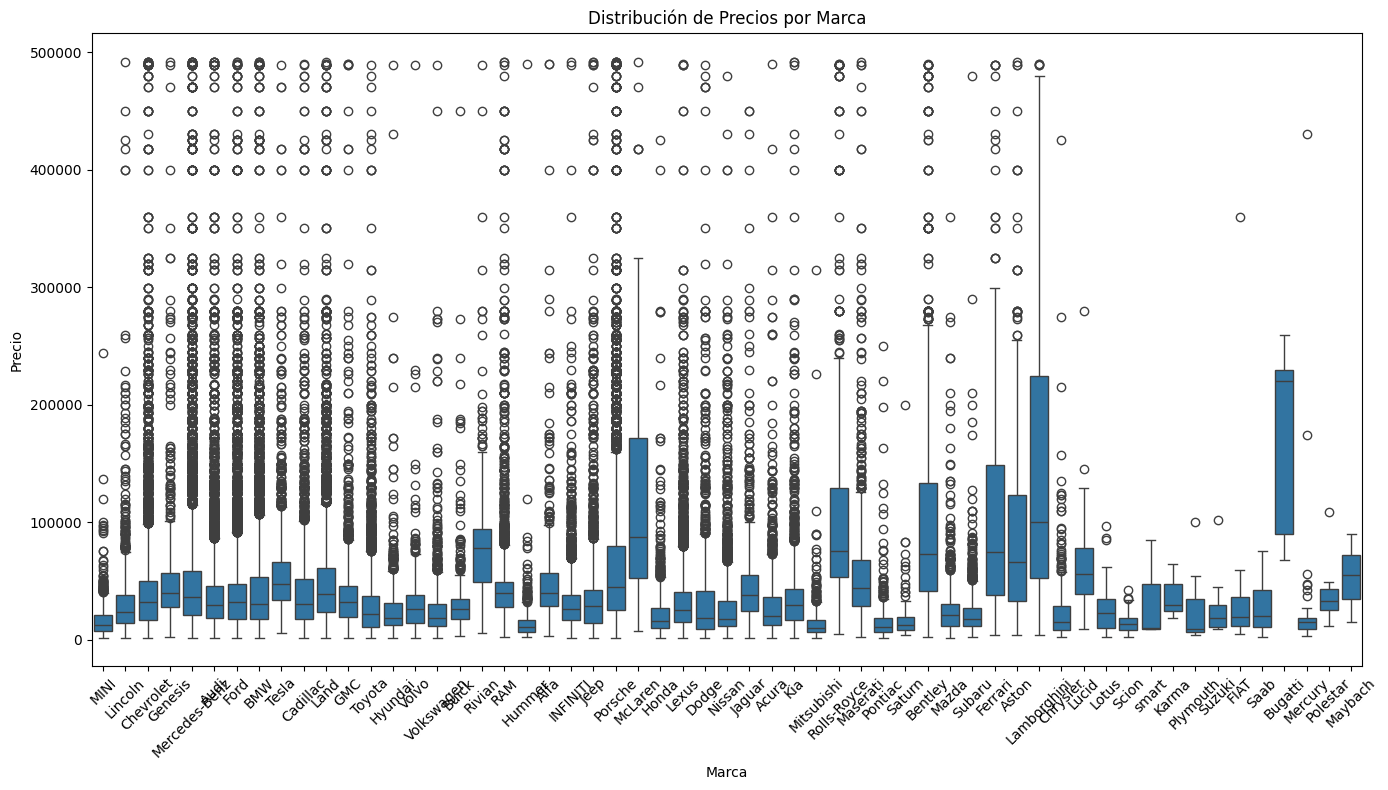

In [23]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_car_clean, x='brand', y='price')
plt.title('Distribución de Precios por Marca')
plt.xlabel('Marca')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Test de ANOVA
- El resultado del test de ANOVA indica que hay diferencias significativas en los precios de los vehículos según la marca, lo que sugiere que el precio de los vehículos varía significativamente entre las diferentes marcas.

In [24]:
import pandas as pd
import scipy.stats as stats

# Crear listas de precios por marca
grouped_prices = [group['price'].values for name, group in df_car_clean.groupby('brand')]
# Crear listas de precios por marca
grouped_prices = [group['price'].values for name, group in df_car_clean.groupby('brand')]
# Aplicar ANOVA de una vía
f_statistic, p_value = stats.f_oneway(*grouped_prices)

print(f"F-statistic: {f_statistic:.2f}")
print(f"P-value: {p_value:.4f}")


F-statistic: 393.08
P-value: 0.0000


p < 0.05, puedes rechazar la hipótesis nula: hay diferencias significativas entre los precios medios de al menos algunas marcas.

# 5 Análisis estadístico

 ## Pruebas paramétricas
 ###   pruebas de normalidad

In [9]:
from scipy.stats import kstest
for col in df_car_clean.select_dtypes(include=['float64', 'int64']).columns:
    data = df_car_clean[col].dropna()
    stat, p = kstest(data, 'norm')
    print(f"{col}: p-value = {p:.4f}")

id: p-value = 0.0000
model_year: p-value = 0.0000
milage: p-value = 0.0000
engine_hp: p-value = 0.0000
engine_cc: p-value = 0.0000
engine_cylinder: p-value = 0.0000
transmission_num: p-value = 0.0000
price: p-value = 0.0000


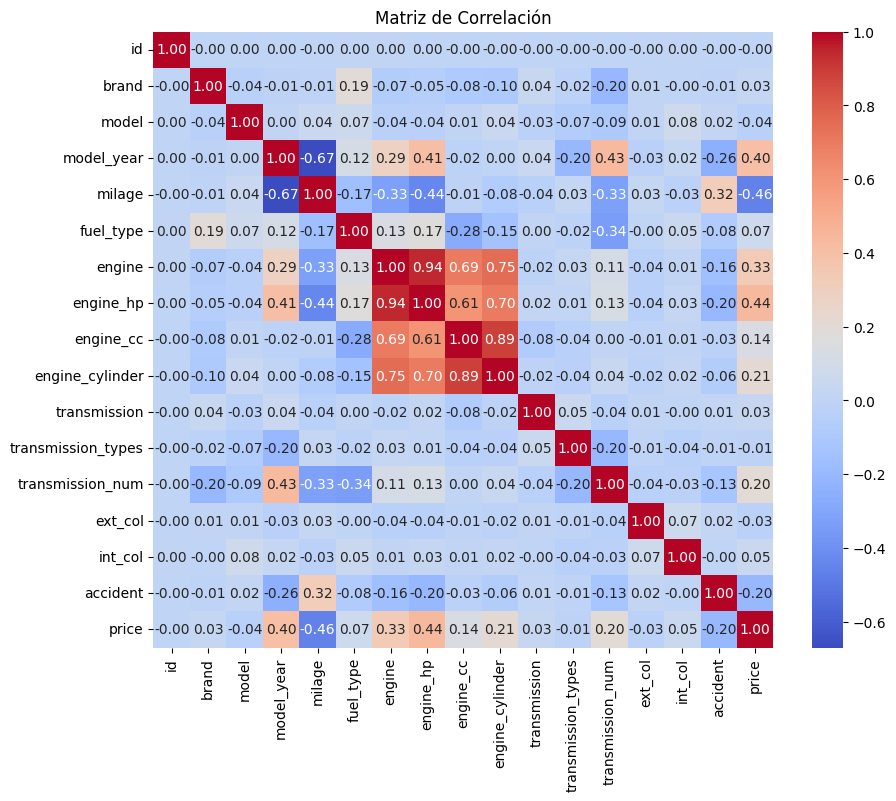

In [12]:
# Copiar el DataFrame original para no modificarlo directamente
df_encoded = df_car.copy()
# Codificar las columnas categóricas con LabelEncoder
label_encoder = LabelEncoder()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()


In [14]:
target_corr = df_encoded.corr()["price"].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo (price):\n", target_corr)


Correlación con la variable objetivo (price):
 price                 1.000000
engine_hp             0.436039
model_year            0.404132
engine                0.332654
engine_cylinder       0.212617
transmission_num      0.201099
engine_cc             0.136964
fuel_type             0.067673
int_col               0.050228
transmission          0.029266
brand                 0.025218
id                   -0.001368
transmission_types   -0.014018
ext_col              -0.028170
model                -0.043408
accident             -0.202579
milage               -0.461400
Name: price, dtype: float64


Hallazgos: 

 ### Shapiro-Wilk

In [ ]:
# from scipy.stats import shapiro

# for col in df_car.select_dtypes(include=['float64', 'int64']).columns:
#     stat, p = shapiro(df_car[col].dropna())
#     print(f"{col}: p-value = {p:.4f}")  # p < 0.05 → no normal

Hallazgos: 

In [15]:
from scipy.stats import kstest

for col in df_car.select_dtypes(include=['float64', 'int64']).columns:
    data = df_car[col].dropna()
    stat, p = kstest(data, 'norm')
    print(f"{col}: p-value = {p:.4f}")

id: p-value = 0.0000
model_year: p-value = 0.0000
milage: p-value = 0.0000
engine_hp: p-value = 0.0000
engine_cc: p-value = 0.0000
engine_cylinder: p-value = 0.0000
transmission_num: p-value = 0.0000
price: p-value = 0.0000


In [16]:
from scipy.stats import ttest_ind

# Ejemplo: Comparar 'strength' entre dos grupos específicos
group_a = df_car_clean[df_car_clean['model_year'] == 'A']['price']
group_b = df_car_clean[df_car_clean['model_year'] == 'B']['price']
t_stat, p_value = ttest_ind(group_a, group_b)
print(f"t-test p-value: {p_value:.4f}")

t-test p-value: nan


c:\Users\Administrator\Desktop\proyecto_5\.venv\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [17]:
from scipy.stats import anderson
result = anderson(df_car["price"])
print("Estadístico AD:", result.statistic)
print("Valores críticos:", result.critical_values)


Estadístico AD: 15100.707315217063
Valores críticos: [0.576 0.656 0.787 0.918 1.092]


## Explicación de este resultado 
 ¿Qué significan estos valores?
Estadístico AD (10528.30):

Es el valor calculado de la prueba. Cuanto mayor sea, más evidencia hay de no normalidad.

En tu caso, es extremadamente alto (¡10528!), lo que indica una desviación masiva de la normalidad.

Valores críticos:

Son umbrales de referencia para diferentes niveles de significancia (15%, 10%, 5%, 2.5%, 1%).

Si el estadístico AD > valor crítico, se rechaza la normalidad en ese nivel de significancia.

Nivel de Significancia	Valor Crítico	Comparación con AD (10528)	Conclusión
15%	0.576	10528 > 0.576	Rechaza normalidad
10%	0.656	10528 > 0.656	Rechaza normalidad
5%	0.787	10528 > 0.787	Rechaza normalidad (estándar)
2.5%	0.918	10528 > 0.918	Rechaza normalidad
1%	1.092	10528 > 1.092	Rechaza normalidad
📌 Conclusión Clave:
Los datos de precios NO siguen una distribución normal en ningún nivel de significancia común (ni siquiera al 1%, el más estricto).

Esto es consistente con tu prueba de Shapiro-Wilk (p-valor ≈ 0).


### Prueba de Homegeneidad de varianza

Nos hemos decantado por Levene porque la prueba de Bartlett es más sensible a desviaciones de normalidad en los datos.

In [18]:
# Ejemplo para comparar varianzas entre grupos (ej: precios por marca)
levene_test = stats.levene(
    df_car[df_car["model_year"] == "milage"]["price"],
    df_car[df_car["model_year"] == "milage"]["price"]
)
print("Levene p-valor:", levene_test.pvalue)

Levene p-valor: nan


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15036\3732061769.py:2: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  levene_test = stats.levene(


Interpretación del Resultado de Levene (p-valor: nan)
El error ocurre porque uno o ambos grupos comparados tienen un tamaño muestral demasiado pequeño para aplicar la prueba de Levene. La función levene() de SciPy requiere un mínimo de observaciones por grupo para calcular las varianzas de manera confiable, y si no se cumple, devuelve NaN.


## Prueba T de Studen

In [31]:
# Comparación de precios entre años 2020 y 2023
grupo_2020 = df_car_clean[df_car_clean["model_year"] == 2020]["price"]
grupo_2023 = df_car_clean[df_car_clean["model_year"] == 2023]["price"]

# Verifica tamaños
print("Grupo 2020:", len(grupo_2020))
print("Grupo 2023:", len(grupo_2023))

# Test t solo si hay datos suficientes
if len(grupo_2020) > 0 and len(grupo_2023) > 0:
    t_result = stats.ttest_ind(grupo_2020, grupo_2023, equal_var=False)
    print("Resultado t-test:", t_result)
else:
    print("Uno o ambos grupos están vacíos. Revisa los filtros.")


Grupo 2020: 15811
Grupo 2023: 8702
Resultado t-test: TtestResult(statistic=np.float64(-39.37146859437873), pvalue=np.float64(0.0), df=np.float64(15762.15810376028))


Interpretación:
Estadístico t (-39.37):

El signo negativo indica que la media del primer grupo (2020) es menor que la del segundo grupo (2023).

La magnitud (39.37) es enorme, lo que sugiere una diferencia muy grande entre las medias.

p-valor (0.0):

Técnicamente, el p-valor nunca es exactamente cero, pero está tan cerca de cero que Python lo redondea a 0.0.

Conclusión: Hay evidencia abrumadora para rechazar la hipótesis nula. Los precios medios de 2020 y 2023 no son iguales.

Grados de libertad (df = 15,762.16):

Es un valor alto (esperado por los tamaños muestrales grandes: 15,811 y 8,702).

Confirma que el test tiene mucha potencia para detectar diferencias.



         price  milage
price   1.0000 -0.4614
milage -0.4614  1.0000
Correlación: -0.461, p-valor: 0.00000


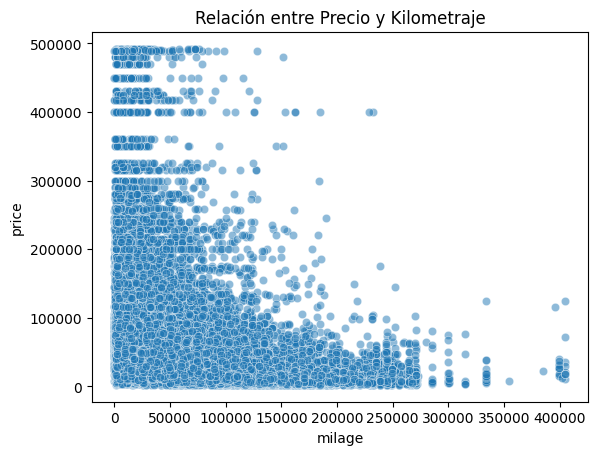

In [21]:
pearson_corr = df_car[["price", "milage"]].corr(method="pearson")
print(pearson_corr)

from scipy.stats import pearsonr

corr, p_value = pearsonr(df_car["price"], df_car["milage"])
print(f"Correlación: {corr:.3f}, p-valor: {p_value:.5f}")
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df_car, x="milage", y="price", alpha=0.5)
plt.title("Relación entre Precio y Kilometraje")
plt.show()

In [24]:
from scipy import stats

# Asumiendo que la columna de marca es "make"
grupo_toyota = df_car_clean[df_car_clean["brand"] == "Toyota"]["price"]
grupo_ford = df_car_clean[df_car_clean["brand"] == "Ford"]["price"]

# Verifica tamaños
print("Toyota:", len(grupo_toyota), "Ford:", len(grupo_ford))

# Si los tamaños son suficientes (n >= 4 en al menos un grupo)
if len(grupo_toyota) >= 4 or len(grupo_ford) >= 4:
    resultado = stats.mannwhitneyu(grupo_toyota, grupo_ford, alternative="two-sided")
    print(resultado)
else:
    print("Muestras demasiado pequeñas para la prueba.")

Toyota: 8846 Ford: 23058
MannwhitneyuResult(statistic=np.float64(75531624.0), pvalue=np.float64(1.3489247749417163e-282))


¿Qué significa esto?
Estadístico U (statistic = 75,531,624.0):

Es el valor calculado por la prueba de Mann-Whitney U.

Cuanto mayor sea este valor, más evidencia hay de que las distribuciones de los dos grupos (Toyota y Ford) no son iguales.

En este caso, el valor es muy alto, lo que sugiere una diferencia significativa.

p-value (pvalue = 1.34e-282):

El p-valor es extremadamente pequeño (prácticamente 0).

Esto indica que hay evidencia estadísticamente significativa para rechazar la hipótesis nula (que las distribuciones de precios entre Toyota y Ford son iguales).

En términos simples: los precios de Toyota y Ford no provienen de la misma distribución.



## Realizando prueba Kruskal-Wallis,

In [27]:
# Filtra por la columna de marca (ej: "brand") en lugar de "model_year":
grupo_toyota = df_car_clean[df_car_clean["brand"] == "Toyota"]["price"]
grupo_ford = df_car_clean[df_car_clean["brand"] == "Ford"]["price"]
grupo_chevrolet = df_car_clean[df_car_clean["brand"] == "Chevrolet"]["price"]

# Ejecuta Kruskal-Wallis
resultado = stats.kruskal(grupo_toyota, grupo_ford, grupo_chevrolet)
print(resultado)

KruskalResult(statistic=np.float64(1400.1890306355465), pvalue=np.float64(8.970469765280244e-305))




Interpretación:
Estadístico H (1400.189):

Es un valor que mide la diferencia entre las distribuciones de los grupos (Toyota, Ford, Chevrolet).

Cuanto mayor sea el valor de H, mayor es la evidencia de que al menos un grupo tiene una distribución diferente a los demás.

En tu caso, el valor es muy alto (1400.189), lo que sugiere diferencias notables.

p-valor (8.97 × 10⁻³⁰⁵):

Este valor es prácticamente cero (es extremadamente pequeño, del orden de 10⁻³⁰⁵).

Interpretación del p-valor:

Si p < 0.05: Se rechaza la hipótesis nula (las distribuciones no son iguales).

En tu caso, p ≈ 0, lo que significa que existe una diferencia estadísticamente significativa en los precios entre al menos dos de las marcas (Toyota, Ford, Chevrolet).

In [28]:
# Spearman
df_car_clean[["price", "milage"]].corr(method="spearman")

# Kendall
df_car_clean[["price", "milage"]].corr(method="kendall")

,price,milage
price,1.000000,-0.553747
milage,-0.553747,1.000000


Si la correlación es negativa (ej: -0.65 en Spearman):

Indica que a mayor kilometraje (milage), menor precio (price).

Esto es esperado en el mercado de autos usados: los vehículos con más kilómetros suelen valer menos.

Si la correlación es cercana a 0 (ej: -0.1):

No hay una relación clara entre kilometraje y precio.

Si la correlación es positiva (raro en este caso):

Sería contradictorio (ej: autos con más kilómetros valen más). Podría deberse a outliers o datos mal filtrados.

 ¿Por qué usar ambos métodos?
Spearman:

Más común y fácil de interpretar.

Ideal para detectar tendencias monótonas (no necesariamente lineales).

Kendall:

Menos sensible a outliers.

Útil cuando hay muchos empates en los datos (ej: muchos autos con 50,000 km).

## Prueba de Fligner


In [30]:
grupo_toyota = df_car_clean[df_car_clean["brand"] == "Toyota"]["price"]
grupo_ford = df_car_clean[df_car_clean["brand"] == "Ford"]["price"]

# Verifica tamaños muestrales
print("Toyota:", len(grupo_toyota), "Ford:", len(grupo_ford))

# Si los tamaños son suficientes (n >= 4), aplica Fligner
if len(grupo_toyota) >= 4 and len(grupo_ford) >= 4:
    resultado = stats.fligner(grupo_toyota, grupo_ford)
    print(resultado)
else:
    print("Muestras demasiado pequeñas para la prueba.")

Toyota: 8846 Ford: 23058
FlignerResult(statistic=np.float64(304.73188644603994), pvalue=np.float64(3.0681675864468114e-68))


La prueba de Fligner-Killeen es un método no paramétrico para verificar la homogeneidad de varianzas (también llamada homocedasticidad) entre dos o más grupos.

Estadístico (304.73):

Un valor alto indica mayor evidencia en contra de la igualdad de varianzas.

En tu caso, 304.73 es extremadamente alto, lo que sugiere diferencias significativas en la dispersión de precios entre Toyota y Ford.

p-valor (3.07 × 10⁻⁶⁸):

Prácticamente cero (muy por debajo de 0.05).

Conclusión: Rechazamos la hipótesis nula. Las varianzas de los precios no son iguales entre Toyota y Ford.

## 5. Análisis Univariante
### 5.1 Estadísticas Descriptivas
- Presentamos las estadísticas descriptivas básicas para entender las características generales de las variables numéricas en el dataset.

In [26]:
df_car_clean = pd.read_csv(clean_data_car_csv_path)
print("Estadísticas descriptivas:")
print(df_car_clean.describe())

Estadísticas descriptivas:
                  id     model_year         milage      engine_hp      engine_cc  engine_cylinder  transmission_num          price
count  188181.000000  188181.000000  188181.000000  155049.000000  181499.000000    173040.000000     188181.000000  188181.000000
mean    94265.116675    2015.825811   65786.058561     343.099020    3774.175064         6.352393          6.793911   41534.308713
std     54421.920930       5.659811   49796.705080     114.632841    1352.210455         1.588061          1.753765   44533.526283
min         0.000000    1974.000000     100.000000      70.000000     650.000000         3.000000          1.000000    2000.000000
25%     47137.000000    2013.000000   24213.000000     263.000000    3000.000000         6.000000          6.000000   17000.000000
50%     94274.000000    2017.000000   57800.000000     328.000000    3500.000000         6.000000          6.000000   30599.000000
75%    141387.000000    2020.000000   95428.000000     4

#### 6.2 Visualización de la Distribución
- Analizamos la distribución de la variable `price` para identificar patrones, sesgos o valores atípicos

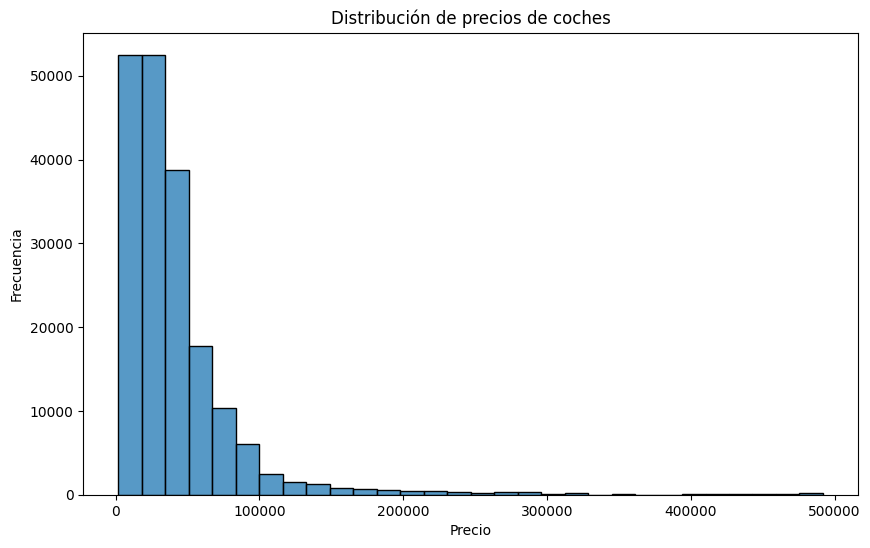

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_car, x='price', bins=30)
plt.title('Distribución de precios de coches')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

Hallazgos: La mayoría de los coches están en el rango de 0 a 100000, también hay coches de lujo con precios significativamente más altos, aunque representan una minoría en el dataset, la distribución no es simétrica, los precios no están distribuidos de manera uniforme.

## 6. Análisis Bivariante
### 6.1 Correlaciones y Relaciones entre Variables

- Nos enfocamos específicamente en la relación entre la variable objetivo price y las posibles variables más relacionadas.

- Creamos un mapa de calor para ver las relaciones entre las variables numéricas.

In [28]:
df_car_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188181 entries, 0 to 188180
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  188181 non-null  int64  
 1   brand               188181 non-null  object 
 2   model               188181 non-null  object 
 3   model_year          188181 non-null  int64  
 4   milage              188181 non-null  int64  
 5   fuel_type           182317 non-null  object 
 6   engine              188181 non-null  object 
 7   engine_hp           155049 non-null  float64
 8   engine_cc           181499 non-null  float64
 9   engine_cylinder     173040 non-null  float64
 10  transmission        188181 non-null  object 
 11  transmission_types  188181 non-null  object 
 12  transmission_num    188181 non-null  int64  
 13  ext_col             188181 non-null  object 
 14  int_col             188181 non-null  object 
 15  accident            188181 non-nul

Index(['id', 'model_year', 'milage', 'engine_hp', 'engine_cc',
       'engine_cylinder', 'transmission_num', 'price'],
      dtype='object')


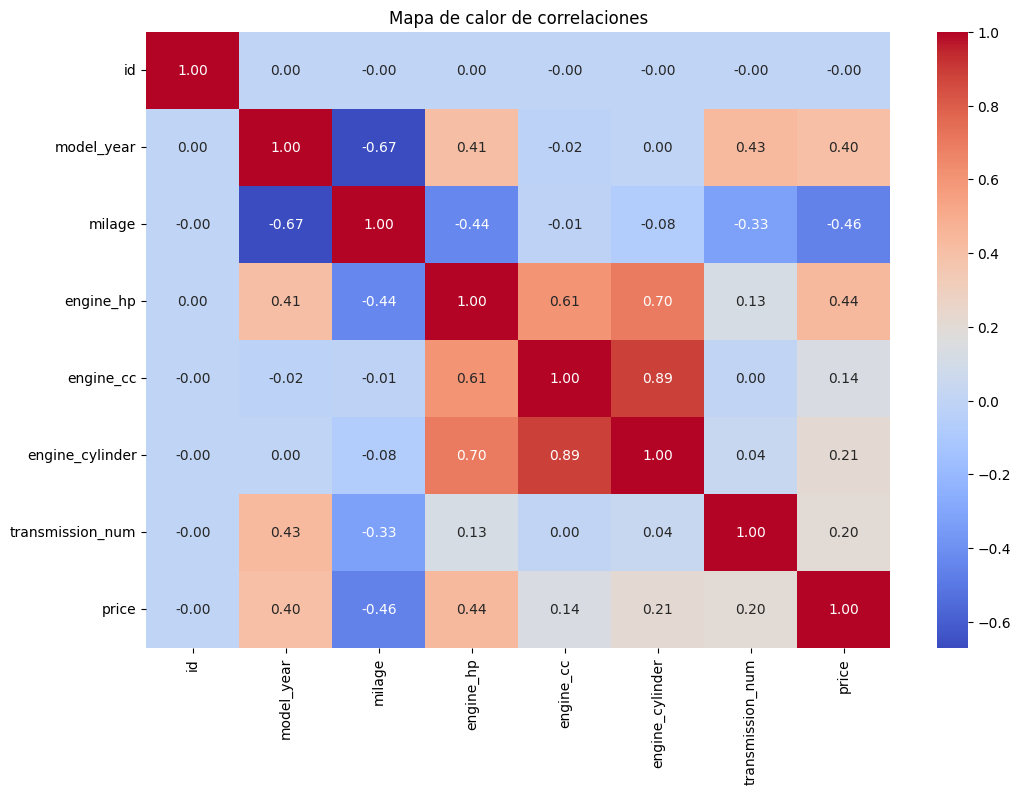

In [29]:
# Filtrar solo las columnas numéricas
numeric_columns = df_car_clean.select_dtypes(include=['float64', 'int64'])
print(numeric_columns.columns)
# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr() 

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de calor de correlaciones")
plt.show()

Hallazgos:  
- Las variables transmission_num y model_year tienen una correlación positiva moderada (0.48), lo que indica que los vehículos más recientes suelen incorporar transmisiones más avanzadas con un mayor número de velocidades (por ejemplo, 6, 7 u 8 marchas) para mejorar la eficiencia del combustible y el rendimiento.
- Se identificaron las variables model_year y milage como relevantes para predecir el precio (price). model_year muestra una correlación positiva moderada con price (0.38), indicando que los coches más nuevos tienden a tener precios más altos. Por otro lado, milage tiene una correlación negativa moderada con price (-0.43), lo que refuerza que los coches con mayor kilometraje suelen tener precios más bajos. Además, milage y model_year tienen una correlación negativa fuerte entre sí (-0.67), lo que es lógico ya que los coches más nuevos tienen menos kilómetros. Ambas variables aportan información complementaria sobre la antigüedad y el uso del coche, siendo útiles para el modelo predictivo.
- La variable engine_cc muestra una correlación positiva débil con price (0.13), indicando que el tamaño del motor tiene una influencia menor en comparación con otras variables clave.
- La variable engine_hp tiene una correlación positiva moderada con price (0.41), lo que sugiere que los coches con mayor potencia del motor tienden a tener precios más altos.

Investigación: 

El motivo por el que los coches no paran de aumentar sus marchas es porque :
El gran motivo detrás de esta tendencia está en la necesidad de los fabricantes de vehículos de adaptarse a las exigentes normas anticontaminación que se han ido aprobando. Así, han tenido que desarrollar motores más eficientes que optimicen su consumo y, por tanto, sus emisiones.

Al tener más marchas más cercanas entre sí, en teoría, se consigue aprovechar mejor toda la energía salida del motor de manera más efectiva, manteniendo las revoluciones dentro de su rango más propicio para obtener una entrega de par motor y potencia máxima.

#### Gráfico de Dispersión
Para visualizar la relación entre price y cada variable relevante.

#### Relación entre diferentes variables
- Creamos una función que genere gráficos de dispersión y calcule la correlación entre diabetes_prevalence y otras variables numéricas que deseemos analizar.

Correlación entre price y engine_cc: 0.14


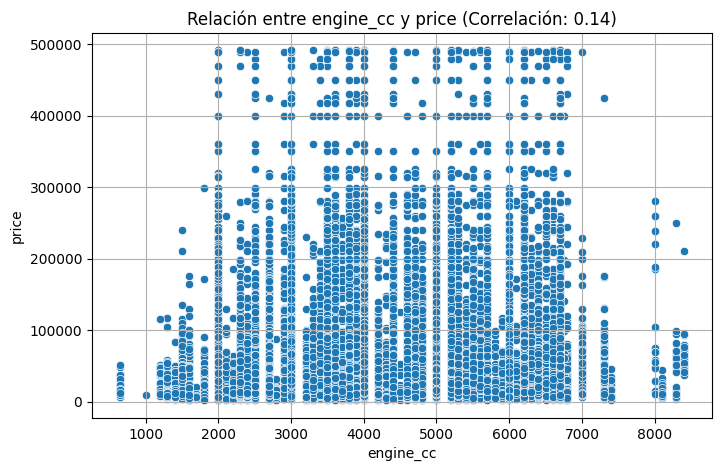

In [30]:
def analyze_relationship(df, target, predictors):
    for predictor in predictors:
        # Calcular la correlación
        correlation = df[target].corr(df[predictor])
        print(f"Correlación entre {target} y {predictor}: {correlation:.2f}")
        
        # Generar gráfico de dispersión
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=df, x=predictor, y=target)
        plt.title(f"Relación entre {predictor} y {target} (Correlación: {correlation:.2f})")
        plt.xlabel(predictor)
        plt.ylabel(target)
        plt.grid()
        plt.show()

# Filtrar las variables predictoras que existen en el DataFrame
predictors = [
    # 'milage', 
    # 'model_year',
    # 'transmission_num', 
    # 'accident', 
    # 'engine_cylinder',
    'engine_hp',
]

analyze_relationship(df_car_clean, target='price', predictors=predictors)

- Milage y price: se muestra una distribución densa de puntos en el rango de precios bajos y kilometraje moderado, lo que sugiere que la mayoría de los vehículos tienen un kilometraje promedio y precios accesibles, también se muestran algunos puntos dispersos que podrían ser los vehículos de lujo.
- Entre model_year y price se observa una tendencia ascendente en los precios a medida que aumenta el año del modelo, es decir los puntos están más concentrados en los años recientes lo que sugiere que la mayoría de los vehículos son relativamente nuevos, esta relación refuerza la importacia de model_year como una variable predictiva.
- transmission_num y price, aunque la correlación es débil, podría ser una variable complementaria combinada con otras ya que sugiere que los vehículos con más marchas suelen ser más modernos o de gama alta lo que subiría el precio.
- La relación entre accident y price, podría ser relevante para explicar la variación en los precios, porque los compradores prefieren vehículos sin accidentes, vamos a hacer un análisis multivariado ya que podría ser más relevante en conjunto con otras variables.
-El gráfico de engine_cc y price sugiere que el tamaño del motor de un vehículo no es un factor determinante importante para predecir su precio

# 8. Preprocesamiento de datos

- Primero vamos a dividir el dataset en entrenamiento y prueba (80-20)

In [31]:
train_csv_path = os.path.join(data_dir, "train_csv.csv")
test_csv_path = os.path.join(data_dir, "test_csv.csv")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_car_clean[['price', 'model_year', 'milage', 'accident', 'engine_hp', 'transmission_num']],  ## engine_cc y transmission_num tienen nulos
    df_car_clean['price'],
    test_size=0.2,
    random_state=42
)
## Guardar los conjuntos de datos
X_train.to_csv(os.path.join(train_csv_path), index=False)
X_test.to_csv(os.path.join(test_csv_path), index=False)

print(f"Entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Entrenamiento: (150544, 3), (150544,)
Test: (37637, 3), (37637,)


In [32]:
df_car_test = pd.read_csv(test_csv_path)
df_car_train = pd.read_csv(train_csv_path)

In [33]:
df_car_test.sample(5)

model_year  milage  accident
7027         2020   28260     False
23234        2018   37000     False
7618         2012  126225      True
28361        2021   15198     False
10052        2002   96600     False

In [34]:
# Verificar NaNs en X_train
print("Valores nulos en X_train:")
print(pd.DataFrame(X_train).isnull().sum())

# Verificar NaNs en X_test
print("\nValores nulos en X_test:")
print(pd.DataFrame(X_test).isnull().sum())

Valores nulos en X_train:
model_year    0
milage        0
accident      0
dtype: int64

Valores nulos en X_test:
model_year    0
milage        0
accident      0
dtype: int64


In [35]:
# total_rows = len(df_car_clean)
# train_percentage = len(X_train) / total_rows * 100
# test_percentage = len(X_test) / total_rows * 100

# print(f"Porcentaje de entrenamiento: {train_percentage:.2f}%")
# print(f"Porcentaje de prueba: {test_percentage:.2f}%")

- Preprocesado mediante StandardScaler, vamos a escalar las variables posiblemente predictoras para mejorar el rendimiento.

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (150544, 3)
X_test_scaled shape: (37637, 3)


- Vamos a probar con el modelo de regresión lineal.

In [37]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

- Creamos el Pipeline:

In [38]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

In [39]:
# Entrenar el pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [40]:
# Realizar predicciones con el pipeline
y_pred = pipeline.predict(X_test)
y_pred_rounded = np.round(y_pred[:5], 2)
# Mostrar las primeras predicciones y valores reales
print(f"Predicciones: {y_pred_rounded}")
print(f"Valores reales: {y_test[:5].values}")

Predicciones: [34620.95 57815.4  27757.33 57844.37 62766.15]
Valores reales: [ 49750  46105   7300  49995 244896]


- Evaluar el modelo:

In [41]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calcula RMSE 
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 1606353425.76
Root Mean Squared Error (RMSE): 40079.34
R-squared (R²): 0.22


# 9. Conclusión: